In [31]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import time
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import warnings
import getpass
import json
warnings.filterwarnings('ignore')


In [32]:
from google.colab import userdata

In [33]:
# Check if running in Google Colab - define this at the very beginning
try:
    import google.colab
    from google.colab import userdata
    from google.colab import drive
    IN_COLAB = True
except:
    IN_COLAB = False

In [34]:
# Set paths for checkpoints and data
if IN_COLAB:
    # Set checkpoint directory to the requested path
    CHECKPOINT_PATH = '/content/drive/MyDrive/icml_face_data'
else:
    CHECKPOINT_PATH = './checkpoints'

In [35]:
# ===== GLOBAL CONFIGURATION =====
# You can modify these variables directly
KAGGLE_USERNAME = "sriramacharya8"  # Replace with your Kaggle username
CONFIG_VERSION = "1.0.0"          # For tracking code version
# =================================



# List of Colab secrets used by this script
REQUIRED_SECRETS = [
    {
        "name": "KAGGLE_API_KEY",
        "description": "Your Kaggle API key for downloading datasets",
        "required": False  # Not strictly required as there are fallback methods
    },
    {
        "name": "WANDB",
        "description": "Your Weights & Biases API key for experiment tracking",
        "required": False  # Optional feature
    }
]

# Use tqdm.notebook for better visibility in notebook environments
if IN_COLAB:
    from tqdm.notebook import tqdm
else:
    from tqdm.auto import tqdm

warnings.filterwarnings('ignore')

# Set device for GPU acceleration
device = torch.device('cuda' if torch.cuda.is_available() else
                     'mps' if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() else
                     'cpu')

In [36]:
"""
Facial Emotion Recognition using PyTorch and Hugging Face Transformers
- Optimized for Google Colab
- Using state-of-the-art models
- Proper GPU utilization
- Efficient data pipeline with Albumentations
- Training visualization with Tensorboard/Weights & Biases
- Early stopping with patience

Dataset: FER2013

=== INSTRUCTIONS ===
1. Set your Kaggle username in the KAGGLE_USERNAME variable below
2. Add your Kaggle API key as a Colab secret named 'KAGGLE_API_KEY'
3. (Optional) Add your Weights & Biases API key as a Colab secret named 'WANDB'
4. Run the script and follow the prompts

To set up Colab secrets:
1. Click on the 🔑 icon in the left sidebar
2. Add each secret with the exact name specified (e.g., 'KAGGLE_API_KEY')
3. Restart the runtime after adding secrets
"""

"\nFacial Emotion Recognition using PyTorch and Hugging Face Transformers\n- Optimized for Google Colab\n- Using state-of-the-art models\n- Proper GPU utilization\n- Efficient data pipeline with Albumentations\n- Training visualization with Tensorboard/Weights & Biases\n- Early stopping with patience\n\nDataset: FER2013\n\n=== INSTRUCTIONS ===\n1. Set your Kaggle username in the KAGGLE_USERNAME variable below\n2. Add your Kaggle API key as a Colab secret named 'KAGGLE_API_KEY'\n3. (Optional) Add your Weights & Biases API key as a Colab secret named 'WANDB'\n4. Run the script and follow the prompts\n\nTo set up Colab secrets:\n1. Click on the 🔑 icon in the left sidebar\n2. Add each secret with the exact name specified (e.g., 'KAGGLE_API_KEY')\n3. Restart the runtime after adding secrets\n"

In [37]:
# Test if API secrets work
import os
import sys

# Detect if running in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # For Google Colab
    try:
        from google.colab import userdata
        wandb_api_key = userdata.get('WANDB')
        if wandb_api_key:
            print("✅ Successfully retrieved WANDB API key from Colab secrets!")
            print(f"API key (first 4 chars): {wandb_api_key[:4]}***")

            # Test if the key actually works with wandb
            try:
                import wandb
                wandb.login(key=wandb_api_key, anonymous="never")
                print("✅ Successfully authenticated with Weights & Biases!")
            except ImportError:
                print("⚠️ wandb not installed. Installing...")
                !pip install -q wandb
                import wandb
                wandb.login(key=wandb_api_key, anonymous="never")
                print("✅ Successfully authenticated with Weights & Biases!")
            except Exception as e:
                print(f"❌ Error authenticating with Weights & Biases: {e}")
        else:
            print("❌ WANDB API key not found in Colab secrets.")
            print("Make sure you've set up the secret correctly in the Colab notebook.")
    except ImportError:
        print("❌ Could not import userdata module. Are you running in Colab?")
    except Exception as e:
        print(f"❌ Error accessing Colab secrets: {e}")
else:
    # For local environment
    wandb_api_key = os.environ.get('WANDB_API_KEY')
    if wandb_api_key:
        print("✅ Found WANDB_API_KEY in environment variables!")
        print(f"API key (first 4 chars): {wandb_api_key[:4]}***")

        # Test if the key actually works with wandb
        try:
            import wandb
            wandb.login(key=wandb_api_key, anonymous="never")
            print("✅ Successfully authenticated with Weights & Biases!")
        except ImportError:
            print("⚠️ wandb not installed. Please install with: pip install wandb")
        except Exception as e:
            print(f"❌ Error authenticating with Weights & Biases: {e}")
    else:
        print("❌ WANDB_API_KEY not found in environment variables.")
        print("Make sure you've set the environment variable correctly.")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


✅ Successfully retrieved WANDB API key from Colab secrets!
API key (first 4 chars): f332***
✅ Successfully authenticated with Weights & Biases!


In [38]:
# Test if Kaggle API secrets work
import os
import sys
import json

# Detect if running in Colab
IN_COLAB = 'google.colab' in sys.modules

def test_kaggle_authentication():
    """Test if Kaggle credentials work by listing available datasets"""
    try:
        from kaggle.api.kaggle_api_extended import KaggleApi
        api = KaggleApi()
        api.authenticate()
        # Try to list datasets to test authentication
        datasets = api.dataset_list(search="iris")
        print("✅ Successfully authenticated with Kaggle API!")
        print(f"Sample dataset retrieved: {datasets[0].ref if datasets else 'None'}")
        return True
    except ImportError:
        print("⚠️ kaggle package not installed. Installing...")
        if IN_COLAB:
            !pip install -q kaggle
            try:
                from kaggle.api.kaggle_api_extended import KaggleApi
                api = KaggleApi()
                api.authenticate()
                print("✅ Successfully authenticated with Kaggle API!")
                return True
            except Exception as e:
                print(f"❌ Error authenticating with Kaggle: {e}")
                return False
        else:
            print("Please install kaggle with: pip install kaggle")
            return False
    except Exception as e:
        print(f"❌ Error authenticating with Kaggle: {e}")
        return False

if IN_COLAB:
    # For Google Colab
    try:
        from google.colab import userdata
        kaggle_username = userdata.get('KAGGLE_USERNAME')
        kaggle_key = userdata.get('KAGGLE_KEY')

        if kaggle_username and kaggle_key:
            print("✅ Successfully retrieved Kaggle credentials from Colab secrets!")
            print(f"Username: {kaggle_username}")
            print(f"API key (first 4 chars): {kaggle_key[:4]}***")

            # Create kaggle.json file (required for kaggle API)
            !mkdir -p ~/.kaggle
            with open('/root/.kaggle/kaggle.json', 'w') as f:
                json.dump({
                    'username': kaggle_username,
                    'key': kaggle_key
                }, f)
            !chmod 600 ~/.kaggle/kaggle.json

            # Test authentication
            test_kaggle_authentication()
        else:
            missing = []
            if not kaggle_username:
                missing.append("KAGGLE_USERNAME")
            if not kaggle_key:
                missing.append("KAGGLE_KEY")
            print(f"❌ Missing Kaggle credentials in Colab secrets: {', '.join(missing)}")
            print("Make sure you've set up the secrets correctly in the Colab notebook.")
    except ImportError:
        print("❌ Could not import userdata module. Are you running in Colab?")
    except Exception as e:
        print(f"❌ Error accessing Colab secrets: {e}")
else:
    # For local environment
    kaggle_username = os.environ.get('KAGGLE_USERNAME')
    kaggle_key = os.environ.get('KAGGLE_KEY')

    # Alternative: Look for ~/.kaggle/kaggle.json
    kaggle_json_path = os.path.expanduser('~/.kaggle/kaggle.json')
    if os.path.exists(kaggle_json_path):
        try:
            with open(kaggle_json_path, 'r') as f:
                credentials = json.load(f)
                if not kaggle_username:
                    kaggle_username = credentials.get('username')
                if not kaggle_key:
                    kaggle_key = credentials.get('key')
            print(f"✅ Found credentials in {kaggle_json_path}")
        except Exception as e:
            print(f"❌ Error reading {kaggle_json_path}: {e}")

    if kaggle_username and kaggle_key:
        print("✅ Found Kaggle credentials!")
        print(f"Username: {kaggle_username}")
        print(f"API key (first 4 chars): {kaggle_key[:4]}***")

        # Test authentication
        test_kaggle_authentication()
    else:
        missing = []
        if not kaggle_username:
            missing.append("sriramacharya8")
        if not kaggle_key:
            missing.append("KAGGLE_KEY")
        print(f"❌ Missing Kaggle credentials: {', '.join(missing)}")
        print("Make sure you've set the environment variables or created ~/.kaggle/kaggle.json")
        print("See: https://github.com/Kaggle/kaggle-api#api-credentials")

✅ Successfully retrieved Kaggle credentials from Colab secrets!
Username: sriramacharya8
API key (first 4 chars): 58c8***
✅ Successfully authenticated with Kaggle API!
Sample dataset retrieved: uciml/iris


In [39]:
# Constants
IMG_SIZE = 224  # Most pretrained models expect 224×224
BATCH_SIZE = 64
NUM_CLASSES = 7
NUM_WORKERS = 4  # Number of workers for data loading
LR = 1e-4
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 30
PATIENCE = 5  # Early stopping patience
SAVE_FREQ = 5  # Save checkpoints every N epochs

In [40]:
# Class mapping
CLASS_NAMES = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

In [41]:
# Function to validate configuration
def validate_config():
    """
    Validate configuration and provide helpful messages for the user

    Returns:
        bool: True if configuration is valid, False otherwise
    """
    config_valid = True

    # Check if running in Colab
    if IN_COLAB:
        print("Running in Google Colab environment.")

        # Check Kaggle username
        if KAGGLE_USERNAME == "yourusername":
            print("\n⚠️ WARNING: Default Kaggle username detected. Please update the KAGGLE_USERNAME variable at the top of the script.")
            print("   You'll need your username and API key to download the dataset from Kaggle.\n")
            config_valid = False

        # Check available secrets
        print("\nChecking Colab secrets configuration:")
        for secret in REQUIRED_SECRETS:
            try:
                value = userdata.get(secret["name"])
                if value:
                    print(f"✅ {secret['name']}: Found")
                else:
                    print(f"❌ {secret['name']}: Not found - {secret['description']}")
                    if secret["required"]:
                        config_valid = False
            except Exception:
                print(f"❌ {secret['name']}: Not found - {secret['description']}")
                if secret["required"]:
                    config_valid = False

        # Print instructions for setting up secrets
        if not config_valid:
            print("\nTo set up Colab secrets:")
            print("1. Click on the 🔑 icon in the left sidebar")
            print("2. Add the required secrets with exactly the names listed above")
            print("3. Restart the runtime after adding secrets")
            print("\nAlternatively, you can continue without secrets and use the interactive prompts when necessary.")
    else:
        print("Not running in Google Colab. Some features may not be available.")

    return config_valid

In [42]:

# Import Hugging Face Transformers after installation
try:
    from transformers import AutoImageProcessor, AutoModelForImageClassification
except ImportError:
    print("Warning: Transformers package not found. It will be installed at runtime.")
    AutoImageProcessor = None
    AutoModelForImageClassification = None

try:
    import wandb
except ImportError:
    print("Warning: Weights & Biases package not found. It will be installed at runtime.")
    wandb = None

In [43]:
class FER2013Dataset(Dataset):
    """
    Custom Dataset for loading FER2013 data
    """
    def __init__(self, data, transform=None, train=True):
        self.data = data
        self.transform = transform
        self.train = train

        # Clean up column names by stripping whitespace
        self.data.columns = self.data.columns.str.strip()
        print(f"Cleaned columns in dataset: {self.data.columns.tolist()}")

        # Map emotions to their names for reference
        self.emotion_map = {
            0: 'Angry',
            1: 'Disgust',
            2: 'Fear',
            3: 'Happy',
            4: 'Sad',
            5: 'Surprise',
            6: 'Neutral'
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            # Get the row
            row = self.data.iloc[idx]

            # Access pixels
            pixel_string = row['pixels']

            # Split pixel string into values
            if isinstance(pixel_string, str):
                pixels = [float(p) for p in pixel_string.split()]
            else:
                # If pixels is not a string, handle accordingly
                raise ValueError(f"Unexpected pixel type: {type(pixel_string)}")

            # Convert to array and reshape
            pixels = np.array(pixels, dtype=np.float32).reshape(48, 48)

            # Normalize to [0, 1] - ensure it's done correctly
            # FER2013 pixel values are in [0, 255]
            pixels = pixels / 255.0

            # Debug check
            if idx == 0:  # Check first image
                print(f"Original pixel range: min={pixels.min()}, max={pixels.max()}")

            # Convert to RGB by repeating grayscale channel
            image = np.repeat(pixels[:, :, np.newaxis], 3, axis=2)

            if self.transform:
                # Use Albumentations for transformation
                augmented = self.transform(image=image)
                image = augmented['image']

            # Get label
            label = int(row['emotion'])

            return image, label

        except Exception as e:
            print(f"Error processing row {idx}: {str(e)}")
            # Return a placeholder to prevent the whole batch from failing
            placeholder_image = np.zeros((48, 48, 3), dtype=np.float32)
            if self.transform:
                augmented = self.transform(image=placeholder_image)
                placeholder_image = augmented['image']
            return placeholder_image, 0

In [44]:
def load_fer2013(csv_path):
    """
    Load the FER2013 dataset from CSV
    """
    print(f"Loading data from {csv_path}...")
    data = pd.read_csv(csv_path)

    # Check if 'Usage' column exists for predefined train/test split
    if 'Usage' in data.columns:
        train_data = data[data['Usage'] == 'Training']
        val_data = data[data['Usage'] == 'PublicTest']
        test_data = data[data['Usage'] == 'PrivateTest']

        print(f"Train data: {len(train_data)}")
        print(f"Validation data: {len(val_data)}")
        print(f"Test data: {len(test_data)}")

        return train_data, val_data, test_data
    else:
        # If no predefined split, randomly split the data
        print("No 'Usage' column found. Performing random split...")

        train_size = int(0.8 * len(data))
        val_size = int(0.1 * len(data))
        test_size = len(data) - train_size - val_size

        train_data, val_data, test_data = np.split(
            data.sample(frac=1, random_state=42),
            [train_size, train_size + val_size]
        )

        print(f"Train data: {len(train_data)}")
        print(f"Validation data: {len(val_data)}")
        print(f"Test data: {len(test_data)}")

        return train_data, val_data, test_data

In [45]:
def create_dataloaders(train_data, val_data, test_data, batch_size=BATCH_SIZE):
    """
    Create data loaders with optimized pipelines using Albumentations
    """
    # Training transforms with data augmentation
    train_transform = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20),
        ], p=0.5),
        A.OneOf([
            A.MotionBlur(blur_limit=5),
            A.GaussianBlur(blur_limit=5),
            A.GaussNoise(var_limit=(5.0, 30.0)),
        ], p=0.5),
        A.Affine(scale=(0.8, 1.2), translate_percent=(-0.1, 0.1), rotate=(-15, 15), shear=(-8, 8)),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
        ToTensorV2(),
    ])

    # Validation/Test transforms (no augmentation)
    val_transform = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
        ToTensorV2(),
    ])

    # Create datasets
    train_dataset = FER2013Dataset(train_data, transform=train_transform, train=True)
    val_dataset = FER2013Dataset(val_data, transform=val_transform, train=False)
    test_dataset = FER2013Dataset(test_data, transform=val_transform, train=False)

    # Calculate class weights for handling class imbalance
    if 'emotion' in train_data.columns:
        class_counts = train_data['emotion'].value_counts().sort_index().values
        class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
        class_weights = class_weights / class_weights.sum() * NUM_CLASSES
        print(f"Class weights: {class_weights}")
    else:
        class_weights = None

    # Create data loaders with efficient loading
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False,
        drop_last=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False,
    )

    return train_loader, val_loader, test_loader, class_weights

In [46]:
def visualize_samples(dataloader, n_samples=5, class_names=None):
    """
    Visualize sample images from the dataloader with enhanced contrast
    """
    # Get class names dictionary if not provided
    if class_names is None:
        class_names = {
            0: 'Angry',
            1: 'Disgust',
            2: 'Fear',
            3: 'Happy',
            4: 'Sad',
            5: 'Surprise',
            6: 'Neutral'
        }

    # Get a batch of samples without affecting other UI elements
    try:
        dataiter = iter(dataloader)
        images, labels = next(dataiter)
    except Exception as e:
        print(f"Error getting samples from dataloader: {e}")
        return

    # Convert tensors to numpy for visualization
    if isinstance(images, torch.Tensor):
        # Convert to numpy
        images = images.permute(0, 2, 3, 1).cpu().numpy()

    # Print min/max values for debugging
    print(f"Image min value: {images.min()}, max value: {images.max()}")

    # Create a new figure for visualization
    plt.figure(figsize=(15, 3))

    # Plot images with enhanced contrast
    for i in range(min(n_samples, len(images))):
        # Create subplot
        plt.subplot(1, n_samples, i+1)

        # Get grayscale image (first channel)
        img = images[i][:,:,0]

        # Enhance contrast
        img_min = img.min()
        img_max = img.max()

        if img_max > img_min:
            enhanced_img = (img - img_min) / (img_max - img_min)
        else:
            enhanced_img = img

        # Display image
        plt.imshow(enhanced_img, cmap='gray')

        # Set title
        label_idx = labels[i].item() if isinstance(labels[i], torch.Tensor) else labels[i]
        plt.title(f"{class_names[label_idx]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print additional diagnostic info
    print("Visualization complete")

In [47]:
def get_model(model_name="microsoft/resnet-50", pretrained=True, num_classes=NUM_CLASSES):
    """
    Load a pre-trained model from Hugging Face and adapt it for our task

    Available models:
    - "microsoft/resnet-50" (default)
    - "google/vit-base-patch16-224"
    - "facebook/convnext-tiny-224"
    - Custom CNN option
    """
    print(f"Loading model: {model_name}")

    if model_name == "custom_cnn":
        # Define a custom CNN if needed
        model = create_custom_cnn(num_classes=num_classes)
    else:
        # Load pretrained model and processor from Hugging Face
        try:
            from transformers import AutoImageProcessor, AutoModelForImageClassification, ResNetForImageClassification

            # Load the model based on its architecture
            if "resnet" in model_name.lower():
                model = ResNetForImageClassification.from_pretrained(
                    model_name,
                    num_labels=num_classes,
                    ignore_mismatched_sizes=True
                )

                # For ResNet models, the classifier is a Sequential module
                # with a dropout, flatten, and linear layer
                # We need to replace just the final linear layer
                in_features = model.classifier[1].in_features
                model.classifier[1] = nn.Linear(in_features, num_classes)

            elif "vit" in model_name.lower():
                model = AutoModelForImageClassification.from_pretrained(
                    model_name,
                    num_labels=num_classes,
                    ignore_mismatched_sizes=True
                )

                # For ViT models
                in_features = model.classifier.in_features
                model.classifier = nn.Linear(in_features, num_classes)

            elif "convnext" in model_name.lower():
                model = AutoModelForImageClassification.from_pretrained(
                    model_name,
                    num_labels=num_classes,
                    ignore_mismatched_sizes=True
                )

                # For ConvNeXT models
                in_features = model.classifier[2].in_features
                model.classifier[2] = nn.Linear(in_features, num_classes)

            else:
                # Generic approach for other models
                model = AutoModelForImageClassification.from_pretrained(
                    model_name,
                    num_labels=num_classes,
                    ignore_mismatched_sizes=True
                )

                # Try to find the classifier and modify it
                if hasattr(model, 'classifier'):
                    if isinstance(model.classifier, nn.Linear):
                        in_features = model.classifier.in_features
                        model.classifier = nn.Linear(in_features, num_classes)
                    elif isinstance(model.classifier, nn.Sequential):
                        # Find the last Linear layer in the Sequential
                        for i in range(len(model.classifier) - 1, -1, -1):
                            if isinstance(model.classifier[i], nn.Linear):
                                in_features = model.classifier[i].in_features
                                model.classifier[i] = nn.Linear(in_features, num_classes)
                                break

            # Load the image processor as well for preprocessing
            image_processor = AutoImageProcessor.from_pretrained(model_name)
            print(f"Successfully loaded {model_name} model with {sum(p.numel() for p in model.parameters())} parameters")

        except Exception as e:
            print(f"Error loading model: {e}")
            print("Falling back to custom CNN...")
            model = create_custom_cnn(num_classes=num_classes)

    # Move model to device
    model = model.to(device)

    # Print model summary
    print(f"Model loaded with {sum(p.numel() for p in model.parameters())} parameters")

    return model

In [48]:
def create_custom_cnn(num_classes=NUM_CLASSES):
    """
    Create a custom CNN model
    """
    class CustomCNN(nn.Module):
        def __init__(self, num_classes):
            super(CustomCNN, self).__init__()

            # Feature extraction layers
            self.features = nn.Sequential(
                # Block 1
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),

                # Block 2
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),

                # Block 3
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),

                # Block 4
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )

            # Classifier layers
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.classifier = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(512, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                nn.Linear(256, num_classes),
            )

        def forward(self, x):
            x = self.features(x)
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.classifier(x)
            return x

    return CustomCNN(num_classes)

In [49]:
# ======= Training and Evaluation =======

class EarlyStopping:
    """
    Early stopping to prevent overfitting
    """
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Save model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [61]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, scheduler=None):
    """
    Train the model for one epoch
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Use tqdm progress bar
    progress_bar = tqdm(dataloader, desc="Training")

    for batch_idx, (inputs, targets) in enumerate(progress_bar):
        # Move data to device
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Handle different output formats
        if hasattr(outputs, 'logits'):
            # For Hugging Face models with structured output
            logits = outputs.logits
        elif isinstance(outputs, dict) and 'logits' in outputs:
            # For some models that return a dictionary
            logits = outputs['logits']
        else:
            # For custom models or models with direct tensor output
            logits = outputs

        # Calculate loss
        loss = criterion(logits, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update metrics
        running_loss += loss.item()
        _, predicted = logits.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': running_loss / (batch_idx + 1),
            'acc': 100. * correct / total
        })

    # Step the scheduler if provided
    if scheduler is not None:
        scheduler.step()

    # Calculate epoch metrics
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """
    Validate the model
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Validation"):
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Handle different output types from different model architectures
            if hasattr(outputs, 'logits'):
                # For Hugging Face models that return an object with logits
                logits = outputs.logits
            elif isinstance(outputs, dict) and 'logits' in outputs:
                # For models that return a dictionary with logits
                logits = outputs['logits']
            else:
                # For custom models or models that return logits directly
                logits = outputs

            # Calculate loss
            loss = criterion(logits, targets)

            # Update metrics
            running_loss += loss.item()
            _, predicted = logits.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Store predictions and targets for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate validation metrics
    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total

    return val_loss, val_acc, all_preds, all_targets

def extract_features(model, dataloader):
    """
    Extract features from the model for further analysis or multimodal integration
    """
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Extracting Features"):
            # Move only inputs to device (targets stay on CPU since we're not computing with them)
            inputs = inputs.to(device)

            # Get features (before the final classification layer)
            # Different handling for different model types
            if hasattr(model, 'resnet'):
                # For Hugging Face ResNetForImageClassification
                features = model.resnet(inputs)
                if isinstance(features, torch.Tensor):
                    # For some ResNet implementations, we need to pool
                    if features.dim() > 2:
                        features = features.mean([2, 3])  # Global pooling

            elif hasattr(model, 'vit') and callable(getattr(model.vit, 'forward', None)):
                # For ViT models
                outputs = model.vit(inputs, output_hidden_states=True)
                if hasattr(outputs, 'last_hidden_state'):
                    features = outputs.last_hidden_state[:, 0]  # CLS token
                else:
                    # Fallback for other ViT output formats
                    features = outputs[0][:, 0]  # First layer, CLS token

            elif hasattr(model, 'backbone') and callable(getattr(model.backbone, 'forward', None)):
                # For models with a backbone
                features = model.backbone(inputs)
                if isinstance(features, torch.Tensor) and features.dim() > 2:
                    features = features.mean([2, 3])  # Global pooling if needed

            elif hasattr(model, 'features') and hasattr(model, 'avgpool'):
                # For custom CNN
                features = model.features(inputs)
                features = model.avgpool(features)
                features = torch.flatten(features, 1)

            else:
                # Fallback method for other model types
                print("Using fallback method for feature extraction")

                # Option 1: Try to get features via forward hook
                activation = {}
                def get_activation(name):
                    def hook(model, input, output):
                        activation[name] = output.detach()
                    return hook

                # Find a module to hook into
                if hasattr(model, 'classifier'):
                    if isinstance(model.classifier, nn.Sequential):
                        # Hook the layer before the classifier
                        hook_module = list(model.children())[-2]
                    else:
                        # If classifier is not Sequential, try the model itself
                        hook_module = model

                    # Register the hook and do a forward pass
                    hook = hook_module.register_forward_hook(get_activation('features'))
                    _ = model(inputs)  # Forward pass

                    if 'features' in activation:
                        features = activation['features']
                        if features.dim() > 2:
                            features = features.mean([2, 3])  # Global pooling if needed
                    else:
                        print("Warning: Hook did not capture features")
                        # Just use the model output
                        outputs = model(inputs)
                        if hasattr(outputs, 'logits'):
                            features = outputs.logits
                        else:
                            features = outputs

                    hook.remove()  # Clean up the hook

                # Option 2: If no classifier found, just use the full model
                else:
                    outputs = model(inputs)
                    if hasattr(outputs, 'logits'):
                        features = outputs.logits
                    elif hasattr(outputs, 'pooler_output'):
                        features = outputs.pooler_output
                    elif hasattr(outputs, 'last_hidden_state'):
                        features = outputs.last_hidden_state[:, 0]  # CLS token
                    else:
                        # Last resort
                        print("Warning: Using model output as features")
                        features = outputs

            # Ensure features is a proper tensor and flatten if needed
            if not isinstance(features, torch.Tensor):
                if hasattr(features, 'pooler_output'):
                    features = features.pooler_output
                elif hasattr(features, 'last_hidden_state'):
                    features = features.last_hidden_state[:, 0]  # CLS token
                else:
                    print(f"Warning: Cannot extract features from {type(features)}")
                    # Skip this batch
                    continue

            # Flatten if needed
            if features.dim() > 2:
                features = features.reshape(features.size(0), -1)  # Flatten all dimensions except batch

            # Move features back to CPU before converting to numpy
            features_cpu = features.cpu()

            # Store features and labels
            all_features.append(features_cpu.numpy())
            all_labels.append(targets.numpy())

    # Concatenate all features and labels
    if all_features and all_labels:  # Check if lists are not empty
        all_features = np.concatenate(all_features, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)
        print(f"Extracted features shape: {all_features.shape}")
        return all_features, all_labels
    else:
        print("Warning: No features were extracted!")
        return np.array([]), np.array([])

In [51]:
def validate(model, dataloader, criterion, device):
    """
    Validate the model
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Validation"):
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Handle different output formats
            if hasattr(outputs, 'logits'):
                # For Hugging Face models with structured output
                logits = outputs.logits
            elif isinstance(outputs, dict) and 'logits' in outputs:
                # For some models that return a dictionary
                logits = outputs['logits']
            else:
                # For custom models or models with direct tensor output
                logits = outputs

            # Calculate loss
            loss = criterion(logits, targets)

            # Update metrics
            running_loss += loss.item()
            _, predicted = logits.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Store predictions and targets for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate validation metrics
    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total

    return val_loss, val_acc, all_preds, all_targets

In [59]:
def train_model(model, train_loader, val_loader, class_weights=None, num_epochs=NUM_EPOCHS,
                lr=LR, weight_decay=WEIGHT_DECAY, patience=PATIENCE, wandb_config=None):
    """
    Train the model with early stopping and learning rate scheduling
    """
    # Initialize criterion with class weights if provided
    if class_weights is not None:
        class_weights = class_weights.to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()

    # Initialize optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    # Create a local checkpoint directory that's not on Google Drive
    LOCAL_CHECKPOINT_PATH = './local_checkpoints'
    os.makedirs(LOCAL_CHECKPOINT_PATH, exist_ok=True)
    print(f"Created local checkpoint directory at {LOCAL_CHECKPOINT_PATH}")

    # Also try to create the Google Drive directory
    try:
        os.makedirs(CHECKPOINT_PATH, exist_ok=True)
        print(f"Created Google Drive checkpoint directory at {CHECKPOINT_PATH}")
        # Test if we can write to the directory by creating a small test file
        test_file_path = os.path.join(CHECKPOINT_PATH, 'test_write.txt')
        with open(test_file_path, 'w') as f:
            f.write('Test write access')
        os.remove(test_file_path)  # Clean up
        print("Successfully verified write access to Google Drive")
        use_google_drive = True
    except Exception as e:
        print(f"Warning: Cannot write to Google Drive: {e}")
        print(f"Will use local directory instead: {LOCAL_CHECKPOINT_PATH}")
        use_google_drive = False

    # Initialize early stopping with the appropriate path
    early_stopping_path = os.path.join(LOCAL_CHECKPOINT_PATH, 'best_model.pt')
    early_stopping = EarlyStopping(
        patience=patience,
        verbose=True,
        path=early_stopping_path
    )

    # Initialize tracker for history
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_val_acc = 0.0

    # Initialize tensorboard (for visualization)
    writer = SummaryWriter(log_dir='logs')

    # Optional: Initialize Weights & Biases
    use_wandb = wandb_config.get('use_wandb', False) if wandb_config else False
    if use_wandb:
        try:
            # Initialize wandb with provided config
            wandb_run = init_wandb(
                project_name=wandb_config.get('project_name', 'fer2013'),
                experiment_name=wandb_config.get('experiment_name', f"{model.__class__.__name__}_{time.strftime('%Y%m%d_%H%M%S')}"),
                config={
                    "model": model.__class__.__name__,
                    "epochs": num_epochs,
                    "batch_size": BATCH_SIZE,
                    "learning_rate": lr,
                    "weight_decay": weight_decay,
                    "patience": patience,
                }
            )
        except Exception as e:
            print(f"Warning: Could not initialize wandb: {e}")
            print("Training will continue without wandb tracking.")
            use_wandb = False

    # Function to safely save checkpoints
    def safe_save_checkpoint(checkpoint_dict, filepath):
        """Safely save checkpoint with error handling"""
        try:
            # First, save to a temporary file
            temp_filepath = filepath + '.tmp'
            torch.save(checkpoint_dict, temp_filepath)

            # If successful, rename to the target filepath
            os.replace(temp_filepath, filepath)
            return True
        except Exception as e:
            print(f"Warning: Failed to save checkpoint to {filepath}: {e}")
            # Try saving to local directory instead
            try:
                local_filepath = os.path.join(LOCAL_CHECKPOINT_PATH, os.path.basename(filepath))
                torch.save(checkpoint_dict, local_filepath)
                print(f"Saved checkpoint to local directory instead: {local_filepath}")
                return True
            except Exception as e2:
                print(f"Error: Failed to save checkpoint to local directory as well: {e2}")
                return False

    print("Starting training...")
    for epoch in range(num_epochs):
        start_time = time.time()

        # Train for one epoch
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )

        # Validate
        val_loss, val_acc, all_preds, all_targets = validate(
            model, val_loader, criterion, device
        )

        # Update learning rate based on validation loss
        scheduler.step(val_loss)

        # Store history
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Log to tensorboard
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/train', train_acc, epoch)
        writer.add_scalar('Accuracy/val', val_acc, epoch)

        # Log to wandb if enabled
        if use_wandb:
            try:
                wandb.log({
                    "train_loss": train_loss,
                    "val_loss": val_loss,
                    "train_acc": train_acc,
                    "val_acc": val_acc,
                    "epoch": epoch,
                    "learning_rate": optimizer.param_groups[0]['lr'],
                    "confusion_matrix": wandb.plot.confusion_matrix(
                        probs=None,
                        y_true=all_targets,
                        preds=all_preds,
                        class_names=list(CLASS_NAMES.values())
                    ) if epoch % 5 == 0 else None  # Log confusion matrix every 5 epochs
                })

                # Log example predictions
                if epoch % 10 == 0:  # Every 10 epochs
                    try:
                        # Get a batch of images
                        images, true_labels = next(iter(val_loader))
                        images = images.to(device)

                        # Get predictions
                        with torch.no_grad():
                            outputs = model(images)

                            # Handle different output formats
                            if hasattr(outputs, 'logits'):
                                # For Hugging Face models with structured output
                                logits = outputs.logits
                            elif isinstance(outputs, dict) and 'logits' in outputs:
                                # For some models that return a dictionary
                                logits = outputs['logits']
                            else:
                                # For custom models or models with direct tensor output
                                logits = outputs

                            _, preds = logits.max(1)

                        # Log images with predictions
                        examples = []
                        for i in range(min(5, len(images))):  # Log up to 5 examples
                            # Denormalize image for display
                            img = images[i].cpu().permute(1, 2, 0).numpy()
                            mean = np.array([0.485, 0.456, 0.406])
                            std = np.array([0.229, 0.224, 0.225])
                            img = std * img + mean
                            img = np.clip(img, 0, 1)

                            # Create caption with true and predicted labels
                            caption = f"True: {CLASS_NAMES[true_labels[i].item()]}, Pred: {CLASS_NAMES[preds[i].item()]}"

                            examples.append(wandb.Image(img, caption=caption))

                        # Log the examples
                        wandb.log({"examples": examples})
                    except Exception as e:
                        print(f"Warning: Could not log example predictions to wandb: {e}")
            except Exception as e:
                print(f"Warning: Error logging to wandb: {e}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            checkpoint_dict = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'train_acc': train_acc,
            }

            # Try to save to Google Drive if allowed
            if use_google_drive:
                drive_filepath = os.path.join(CHECKPOINT_PATH, 'best_model_checkpoint.pt')
                safe_save_checkpoint(checkpoint_dict, drive_filepath)

            # Always save a local copy as backup
            local_filepath = os.path.join(LOCAL_CHECKPOINT_PATH, 'best_model_checkpoint.pt')
            safe_save_checkpoint(checkpoint_dict, local_filepath)

            print(f"Saved best model with val_acc: {val_acc:.2f}%")

        # Save checkpoint periodically
        if epoch % SAVE_FREQ == 0:
            checkpoint_dict = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'train_acc': train_acc,
            }

            # Try to save to Google Drive if allowed
            if use_google_drive:
                drive_filepath = os.path.join(CHECKPOINT_PATH, f'checkpoint_epoch_{epoch}.pt')
                safe_save_checkpoint(checkpoint_dict, drive_filepath)

            # Always save a local copy as backup
            local_filepath = os.path.join(LOCAL_CHECKPOINT_PATH, f'checkpoint_epoch_{epoch}.pt')
            safe_save_checkpoint(checkpoint_dict, local_filepath)

        # Early stopping check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

        # Calculate epoch time
        epoch_time = time.time() - start_time

        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.2f}% | "
              f"Time: {epoch_time:.2f}s")

    # Close tensorboard writer
    writer.close()

    # Close wandb if enabled
    if use_wandb:
        try:
            wandb.finish()
        except Exception as e:
            print(f"Warning: Error closing wandb: {e}")

    # Load best model - use local path as fallback
    try:
        best_model_path = os.path.join(CHECKPOINT_PATH, 'best_model.pt') if use_google_drive else os.path.join(LOCAL_CHECKPOINT_PATH, 'best_model.pt')
        if not os.path.exists(best_model_path):
            best_model_path = os.path.join(LOCAL_CHECKPOINT_PATH, 'best_model.pt')

        if os.path.exists(best_model_path):
            model.load_state_dict(torch.load(best_model_path))
            print(f"Loaded best model from {best_model_path}")
        else:
            print(f"Warning: Could not find best model at {best_model_path}, using current model state")
    except Exception as e:
        print(f"Warning: Error loading best model: {e}. Using current model state.")

    # Plot training history
    plot_training_history(train_losses, val_losses, train_accs, val_accs)

    return model, train_losses, val_losses, train_accs, val_accs

In [57]:
def plot_confusion_matrix(all_preds, all_targets, class_names=CLASS_NAMES):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Per-class accuracy
    print("\nPer-class accuracy:")
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    for i, acc in enumerate(per_class_acc):
        print(f"{class_names[i]}: {acc:.4f}")

def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    """
    Plot training history
    """
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test set
    """
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Handle different output formats
            if hasattr(outputs, 'logits'):
                # For Hugging Face models with structured output
                logits = outputs.logits
            elif isinstance(outputs, dict) and 'logits' in outputs:
                # For some models that return a dictionary
                logits = outputs['logits']
            else:
                # For custom models or models with direct tensor output
                logits = outputs

            # Get predictions
            _, predicted = logits.max(1)

            # Store predictions and targets
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_targets, all_preds) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds, target_names=list(CLASS_NAMES.values())))

    # Plot confusion matrix
    plot_confusion_matrix(all_preds, all_targets)

    return accuracy, all_preds, all_targets

def extract_features(model, dataloader):
    """
    Extract features from the model for further analysis or multimodal integration
    """
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Extracting Features"):
            # Move only inputs to device (targets stay on CPU since we're not computing with them)
            inputs = inputs.to(device)

            # Get features (before the final classification layer)
            if hasattr(model, 'classifier'):
                # For models like ResNet
                features = model.backbone(inputs)
                # Handle different model architectures
                if isinstance(features, torch.Tensor):
                    features = features.view(features.size(0), -1)
                else:
                    # For models that return dictionaries or tuples
                    features = features.pooler_output if hasattr(features, 'pooler_output') else features.last_hidden_state[:, 0]
            else:
                # For custom models, extract features before the classifier
                features = model.features(inputs)
                features = model.avgpool(features)
                features = torch.flatten(features, 1)

            # Move features back to CPU before converting to numpy
            features_cpu = features.cpu()

            # Store features and labels
            all_features.append(features_cpu.numpy())
            all_labels.append(targets.numpy())

    # Concatenate all features and labels
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_features, all_labels

def show_kaggle_api_instructions():
    """
    Display instructions for finding Kaggle API key
    """
    instructions = """
    =========================================================================
                    HOW TO FIND YOUR KAGGLE API KEY
    =========================================================================

    1. Go to https://www.kaggle.com/
    2. Sign in to your account (or create one if needed)
    3. Click on your profile picture in the top-right corner
    4. Select "Account" from the dropdown menu
    5. Scroll down to the "API" section
    6. Click "Create New API Token"
    7. This will download a kaggle.json file containing your API credentials
    8. Open the file and copy the "key" value

    Then you can either:

    A) Add it as a Colab secret named 'KAGGLE_API_KEY'
       - Click on the 🔑 icon in the left sidebar
       - Add a new secret with name: KAGGLE_API_KEY and your key as the value
       - Restart the runtime

    B) Enter it when prompted in this script

    Make sure to also set your KAGGLE_USERNAME at the top of this script!

    =========================================================================
    """
    print(instructions)

def setup_kaggle_auth():
    """
    Set up Kaggle authentication using username from global variable and API key from Colab secrets

    Returns:
        bool: True if authentication was successful, False otherwise
    """
    print("\n🔑 Setting up Kaggle authentication...")

    # Create kaggle directory if it doesn't exist
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

    kaggle_json_path = os.path.expanduser("~/.kaggle/kaggle.json")

    # First, check if kaggle.json already exists
    if os.path.exists(kaggle_json_path):
        print("✅ Kaggle configuration already exists.")
        return True

    # Try to get Kaggle API key from Colab secrets
    kaggle_api_key = None
    if IN_COLAB:
        try:
            kaggle_api_key = userdata.get('KAGGLE_API_KEY')
            if kaggle_api_key:
                print("✅ Found Kaggle API key in Colab secrets.")
            else:
                print("❌ No Kaggle API key found in Colab secrets.")
        except Exception as e:
            print(f"❌ Error accessing Kaggle API key from secrets: {e}")

    # Check if the global username is set
    if KAGGLE_USERNAME == "yourusername":
        print("⚠️ Please update the KAGGLE_USERNAME at the top of the script with your actual username.")
        username = input("\nEnter your Kaggle username (or press Enter to try manual upload): ")
        if username:
            # Update the global variable
            KAGGLE_USERNAME = username
            print(f"Username set to: {KAGGLE_USERNAME}")
        else:
            # If no username provided and no API key from secrets, check if the user wants to try manual method
            if not kaggle_api_key:
                show_kaggle_api_instructions()
                use_manual = input("\nDo you want to upload kaggle.json manually instead? (y/n): ")
                if use_manual.lower() == 'y':
                    print("Please upload your kaggle.json file.")
                    # Fall back to manual upload
                    if IN_COLAB:
                        from google.colab import files
                        uploaded = files.upload()

                        if 'kaggle.json' in uploaded:
                            !cp kaggle.json ~/.kaggle/
                            !chmod 600 ~/.kaggle/kaggle.json
                            print("✅ Kaggle credentials uploaded successfully.")
                            return True
                        else:
                            print("❌ No kaggle.json file was uploaded.")
                            return False
                    else:
                        print("❌ Manual upload is only supported in Google Colab.")
                        return False
                return False

    # If we don't have an API key yet but we have a username, ask for the key
    if not kaggle_api_key and KAGGLE_USERNAME != "yourusername":
        show_kaggle_api_instructions()
        print(f"\nEnter the API key for Kaggle username '{KAGGLE_USERNAME}':")
        kaggle_api_key = getpass.getpass("API Key (input will be hidden): ")

    # If we have both username and API key, create the kaggle.json file
    if kaggle_api_key and KAGGLE_USERNAME != "yourusername":
        kaggle_config = {
            "username": KAGGLE_USERNAME,
            "key": kaggle_api_key
        }

        # Write the config to kaggle.json
        try:
            with open(kaggle_json_path, "w") as f:
                json.dump(kaggle_config, f)

            # Set proper permissions
            os.chmod(kaggle_json_path, 0o600)
            print("✅ Kaggle authentication configured successfully.")
            return True
        except Exception as e:
            print(f"❌ Error creating Kaggle configuration: {e}")
            return False

    # If we get here, we were unable to set up Kaggle authentication
    print("❌ Unable to set up Kaggle authentication. Please make sure KAGGLE_USERNAME is set and KAGGLE_API_KEY is available in Colab secrets.")
    print("   Alternatively, you can upload kaggle.json manually or download the dataset from Kaggle website.")
    return False

def setup_environment():
    """
    Setup the initial environment, checking for required packages and GPU
    """
    # Display introduction
    display_intro()

    # Check for Colab environment
    if IN_COLAB:
        print("🔍 Environment: Google Colab")

        # Check for GPU
        if torch.cuda.is_available():
            gpu_info = !nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader
            print(f"🚀 GPU: {gpu_info[0]}")
        else:
            print("⚠️ No GPU detected. Performance will be limited.")
            print("   Consider activating a GPU runtime: Runtime > Change runtime type > Hardware accelerator > GPU")

        # Install required packages
        print("\n📦 Installing required packages...")
        !pip install -q transformers albumentations wandb

        # Import Hugging Face Transformers
        try:
            from transformers import AutoImageProcessor, AutoModelForImageClassification
            print("✅ Transformers package installed successfully")
        except ImportError:
            print("❌ Failed to import Transformers. Try restarting the runtime.")
    else:
        print("🔍 Environment: Local Python")

        # Check for required packages
        missing_packages = []
        try:
            import transformers
        except ImportError:
            missing_packages.append("transformers")

        try:
            import albumentations
        except ImportError:
            missing_packages.append("albumentations")

        try:
            import wandb
        except ImportError:
            missing_packages.append("wandb")

        if missing_packages:
            print(f"⚠️ Missing packages: {', '.join(missing_packages)}")
            print("   Install them with pip: pip install " + " ".join(missing_packages))
        else:
            print("✅ All required packages are installed")

    # Check for device
    device_name = "CPU"
    if torch.cuda.is_available():
        device_name = f"GPU ({torch.cuda.get_device_name(0)})"
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device_name = "MPS (Apple Silicon)"

    print(f"\n💻 Using device: {device_name}")

    # Return validation result
    return validate_config()
def setup_wandb_auth():
    """
    Setup Weights & Biases authentication

    Returns:
        dict: Wandb configuration with authentication status
    """
    wandb_config = {'use_wandb': False}

    print("\n🔧 Setting up Weights & Biases for experiment tracking...")
    try:
        import wandb

        # Check if wandb is installed
        print("✅ Weights & Biases is installed.")

        # Try to get API key from Colab secrets
        wandb_api_key = None
        if IN_COLAB:
            try:
                wandb_api_key = userdata.get('WANDB')
                if wandb_api_key:
                    print("✅ Found Weights & Biases API key in Colab secrets.")
                else:
                    print("⚠️ No Weights & Biases API key found in Colab secrets.")
            except Exception as e:
                print(f"⚠️ Error accessing Weights & Biases API key from secrets: {e}")

        # Check if already logged in
        try:
            if wandb_api_key:
                wandb.login(key=wandb_api_key, anonymous="never")
                print("✅ Successfully logged into Weights & Biases with API key from secrets.")
                wandb_config['use_wandb'] = True
            else:
                # Try existing login
                wandb.login(anonymous="never")
                print("✅ Already logged into Weights & Biases.")
                wandb_config['use_wandb'] = True
        except wandb.errors.CommError:
            # Not logged in, ask for API key
            print("\nTo use Weights & Biases for experiment tracking, you need to authenticate.")
            print("You can find your API key at https://wandb.ai/authorize")
            print("Note: If you don't want to use wandb, just press Enter to skip.")

            manual_api_key = getpass.getpass("Enter your Weights & Biases API key (or press Enter to skip): ")

            if manual_api_key:
                try:
                    # Try to login with provided key
                    wandb.login(key=manual_api_key, anonymous="never")
                    print("✅ Successfully logged into Weights & Biases!")
                    wandb_config['use_wandb'] = True
                except Exception as e:
                    print(f"❌ Error logging into Weights & Biases: {e}")
                    print("Continuing without wandb tracking.")
            else:
                print("Skipping Weights & Biases setup.")

        # If successfully logged in, ask for project details
        if wandb_config['use_wandb']:
            project_name = input("Enter project name (default: 'fer2013'): ") or "fer2013"
            experiment_name = input("Enter experiment name (default: auto-generated): ") or None

            wandb_config.update({
                'project_name': project_name,
                'experiment_name': experiment_name
            })

    except ImportError:
        print("⚠️ Weights & Biases (wandb) is not installed. Installing now...")
        if IN_COLAB:
            !pip install -q wandb
            try:
                import wandb
                print("✅ Successfully installed wandb. Now setting up authentication...")

                # Try to get API key from Colab secrets
                wandb_api_key = None
                try:
                    wandb_api_key = userdata.get('WANDB')
                    if wandb_api_key:
                        print("✅ Found Weights & Biases API key in Colab secrets.")
                    else:
                        print("⚠️ No Weights & Biases API key found in Colab secrets.")
                except Exception:
                    print("⚠️ Error accessing Weights & Biases API key from secrets.")

                if wandb_api_key:
                    try:
                        wandb.login(key=wandb_api_key, anonymous="never")
                        print("✅ Successfully logged into Weights & Biases with API key from secrets.")

                        project_name = input("Enter project name (default: 'fer2013'): ") or "fer2013"
                        experiment_name = input("Enter experiment name (default: auto-generated): ") or None

                        wandb_config.update({
                            'use_wandb': True,
                            'project_name': project_name,
                            'experiment_name': experiment_name
                        })
                    except Exception as e:
                        print(f"❌ Error logging into Weights & Biases: {e}")
                else:
                    print("To use Weights & Biases for experiment tracking, you need to authenticate.")
                    print("You can find your API key at https://wandb.ai/authorize")
                    manual_api_key = getpass.getpass("Enter your Weights & Biases API key (or press Enter to skip): ")

                    if manual_api_key:
                        try:
                            wandb.login(key=manual_api_key, anonymous="never")
                            print("✅ Successfully logged into Weights & Biases!")

                            project_name = input("Enter project name (default: 'fer2013'): ") or "fer2013"
                            experiment_name = input("Enter experiment name (default: auto-generated): ") or None

                            wandb_config.update({
                                'use_wandb': True,
                                'project_name': project_name,
                                'experiment_name': experiment_name
                            })
                        except Exception as e:
                            print(f"❌ Error logging into Weights & Biases: {e}")
                    else:
                        print("Skipping Weights & Biases setup.")
            except ImportError:
                print("❌ Could not import wandb after installation. Continuing without wandb tracking.")
        else:
            print("Please install wandb manually with 'pip install wandb' to use this feature.")

    return wandb_config
def display_intro():
    """
    Display introduction and instructions
    """
    intro = """
    =========================================================================
                FACIAL EMOTION RECOGNITION PIPELINE
    =========================================================================

    This script implements a state-of-the-art facial emotion recognition
    pipeline using PyTorch and Hugging Face Transformers. It is optimized
    for Google Colab and can use GPU acceleration for training.

    Features:
    - Multiple model architectures (ResNet, ViT, ConvNeXT)
    - Efficient data loading with Albumentations
    - Full visualization with TensorBoard/Weights & Biases
    - Early stopping and model checkpointing
    - Feature extraction for multimodal integration

    Dataset: FER2013 (from Kaggle)

    =========================================================================
    """
    print(intro)

def init_wandb(project_name, experiment_name=None, config=None):
    """
    Initialize a wandb run with the given configuration

    Args:
        project_name (str): Name of the wandb project
        experiment_name (str, optional): Name of the experiment. If None, auto-generated
        config (dict, optional): Configuration parameters for the experiment

    Returns:
        wandb.Run: The wandb run object
    """
    try:
        import wandb
        run = wandb.init(
            project=project_name,
            name=experiment_name,
            config=config,
            reinit=True
        )

        # Print wandb dashboard URL
        print(f"Weights & Biases dashboard: {run.get_url()}")
        return run
    except Exception as e:
        raise Exception(f"Failed to initialize wandb: {e}")




In [55]:
def main():
  """
  Main function to run the pipeline
  """
  # Setup environment and display intro
  config_valid = setup_environment()

  # Mount Google Drive if in Colab
  if IN_COLAB:
      print("\n🔄 Mounting Google Drive...")
      drive.mount('/content/drive')

      # Create directories
      os.makedirs(CHECKPOINT_PATH, exist_ok=True)
      print(f"✅ Checkpoint directory created at: {CHECKPOINT_PATH}")

      # Display Colab secrets usage info
      print("\n📝 USING SECRETS IN GOOGLE COLAB")
      print("This script can use the following Colab secrets:")
      print("- KAGGLE_API_KEY: For downloading the dataset")
      print("- WANDB: For experiment tracking with Weights & Biases")
      print("\nTo add secrets in Colab:")
      print("1. Click the 🔑 icon in the left sidebar")
      print("2. Add secrets with the exact names listed above")
      print("3. Restart the runtime\n")
  else:
      os.makedirs(CHECKPOINT_PATH, exist_ok=True)

  # Check for configuration issues
  if not config_valid:
      proceed = input("\n⚠️ Some configuration issues were detected. Do you want to proceed anyway? (y/n): ")
      if proceed.lower() != 'y':
          print("Exiting. Please fix the configuration issues and run again.")
          return

  print("\n🚀 Starting pipeline execution...")

  # Step 1: Load dataset
  csv_path = "/content/drive/MyDrive/icml_face_data/icml_face_data.csv"

  if not os.path.exists(csv_path):
      # Download dataset if not available
      if IN_COLAB:
          # In Colab, download from Kaggle
          print("Downloading dataset from Kaggle...")
          !pip install -q kaggle

          # Set up Kaggle authentication
          if setup_kaggle_auth():
              # Download the dataset
              !kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
              !unzip -q fer2013.zip
          else:
              print("Failed to set up Kaggle authentication. Cannot download dataset.")
              print("Please download the dataset manually from Kaggle and upload it to Colab.")
              return
      else:
          raise FileNotFoundError(f"Dataset not found at {csv_path}")

  train_data, val_data, test_data = load_fer2013(csv_path)

  # Step 2: Create data loaders
  train_loader, val_loader, test_loader, class_weights = create_dataloaders(
      train_data, val_data, test_data, batch_size=BATCH_SIZE
  )

  # Step 3: Visualize some samples
  visualize_samples(train_loader)

  # Step 4: Choose model architecture
  default_model = "microsoft/resnet-50"


  model_name = default_model


  print(f"\nUsing model: {model_name}")

  # Load model
  model = get_model(model_name=model_name)

  # Step 5: Setup Weights & Biases (optional)
  print("\nSetting up experiment tracking...")
  wandb_config = setup_wandb_auth()

  # Save experiment configuration
  experiment_config = {
      'model_name': model_name,
      'batch_size': BATCH_SIZE,
      'image_size': IMG_SIZE,
      'learning_rate': LR,
      'weight_decay': WEIGHT_DECAY,
      'num_epochs': NUM_EPOCHS,
      'early_stopping_patience': PATIENCE,
      'train_size': len(train_data),
      'val_size': len(val_data),
      'test_size': len(test_data),
      'date': time.strftime('%Y-%m-%d_%H-%M-%S')
  }

  # Save config to file for reproducibility
  os.makedirs('experiment_configs', exist_ok=True)
  config_filename = f'experiment_configs/config_{time.strftime("%Y%m%d_%H%M%S")}.json'
  with open(config_filename, 'w') as f:
      json.dump(experiment_config, f, indent=4)

  print(f"\nExperiment configuration saved to {config_filename}")

  # Step 6: Train model
  trained_model, train_losses, val_losses, train_accs, val_accs = train_model(
      model, train_loader, val_loader, class_weights=class_weights,
      num_epochs=NUM_EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY, patience=PATIENCE,
      wandb_config=wandb_config
  )

  # Step 7: Evaluate model
  accuracy, all_preds, all_targets = evaluate_model(trained_model, test_loader)

  # Step 8: Extract features for multimodal integration
  print("Extracting features for potential multimodal integration...")
  features, labels = extract_features(trained_model, test_loader)
  print(f"Extracted features shape: {features.shape}")

  print("Pipeline completed successfully!")
  return trained_model, accuracy




                FACIAL EMOTION RECOGNITION PIPELINE

    This script implements a state-of-the-art facial emotion recognition
    pipeline using PyTorch and Hugging Face Transformers. It is optimized
    for Google Colab and can use GPU acceleration for training.

    Features:
    - Multiple model architectures (ResNet, ViT, ConvNeXT)
    - Efficient data loading with Albumentations
    - Full visualization with TensorBoard/Weights & Biases
    - Early stopping and model checkpointing
    - Feature extraction for multimodal integration

    Dataset: FER2013 (from Kaggle)

    
🔍 Environment: Google Colab
🚀 GPU: Tesla T4, 15360 MiB, 8404 MiB

📦 Installing required packages...
✅ Transformers package installed successfully

💻 Using device: GPU (Tesla T4)
Running in Google Colab environment.

Checking Colab secrets configuration:
✅ KAGGLE_API_KEY: Found
✅ WANDB: Found

🔄 Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/c

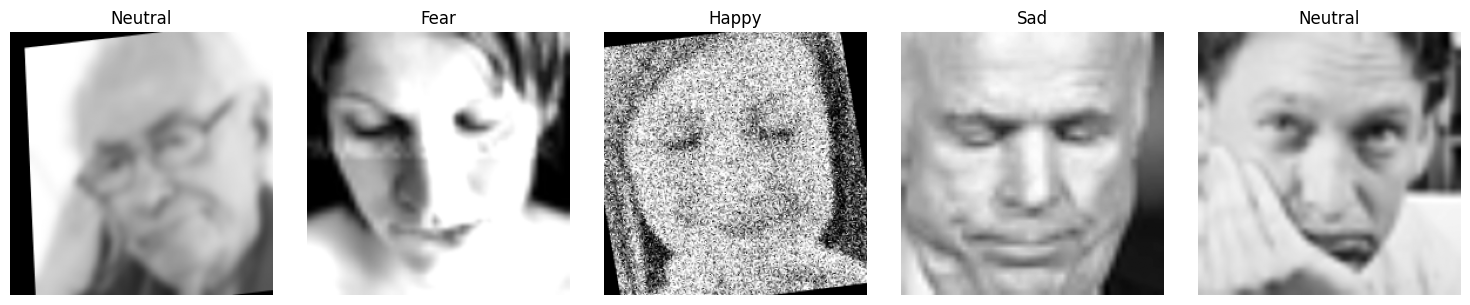

Visualization complete

Using model: microsoft/resnet-50
Loading model: microsoft/resnet-50


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([7, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successfully loaded microsoft/resnet-50 model with 23522375 parameters
Model loaded with 23522375 parameters

Setting up experiment tracking...

🔧 Setting up Weights & Biases for experiment tracking...
✅ Weights & Biases is installed.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


✅ Found Weights & Biases API key in Colab secrets.
✅ Successfully logged into Weights & Biases with API key from secrets.
Enter project name (default: 'fer2013'): featureExtractionFace
Enter experiment name (default: auto-generated): resnet-50 microsoft

Experiment configuration saved to experiment_configs/config_20250415_064459.json
Created local checkpoint directory at ./local_checkpoints
Created Google Drive checkpoint directory at /content/drive/MyDrive/icml_face_data
Successfully verified write access to Google Drive


epoch,▁
learning_rate,▁
train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
epoch,0
learning_rate,0.0001
train_acc,21.4216
train_loss,1.88819
val_acc,15.32887


Weights & Biases dashboard: https://wandb.ai/sriramac-university-of-southern-california/featureExtractionFace/runs/fg6atssp
Starting training...


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Original pixel range: min=0.0117647061124444, max=0.9843137264251709


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Original pixel range: min=0.0, max=0.8235294222831726
Original pixel range: min=0.0, max=0.8235294222831726
Saved checkpoint to local directory instead: ./local_checkpoints/best_model_checkpoint.pt
Saved best model with val_acc: 17.50%
Validation loss decreased (inf --> 1.937763). Saving model...
Epoch 1/30 | Train Loss: 1.8974 | Train Acc: 21.83% | Val Loss: 1.9378 | Val Acc: 17.50% | Time: 307.39s


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Original pixel range: min=0.0117647061124444, max=0.9843137264251709


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Original pixel range: min=0.0, max=0.8235294222831726
Saved checkpoint to local directory instead: ./local_checkpoints/best_model_checkpoint.pt
Saved best model with val_acc: 33.81%
Validation loss decreased (1.937763 --> 1.744623). Saving model...
Epoch 2/30 | Train Loss: 1.7586 | Train Acc: 31.28% | Val Loss: 1.7446 | Val Acc: 33.81% | Time: 300.95s


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Original pixel range: min=0.0117647061124444, max=0.9843137264251709


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Original pixel range: min=0.0, max=0.8235294222831726
Saved checkpoint to local directory instead: ./local_checkpoints/best_model_checkpoint.pt
Saved best model with val_acc: 44.59%
Validation loss decreased (1.744623 --> 1.507015). Saving model...
Epoch 3/30 | Train Loss: 1.5731 | Train Acc: 38.77% | Val Loss: 1.5070 | Val Acc: 44.59% | Time: 300.20s


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Original pixel range: min=0.0117647061124444, max=0.9843137264251709


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Original pixel range: min=0.0, max=0.8235294222831726
Saved checkpoint to local directory instead: ./local_checkpoints/best_model_checkpoint.pt
Saved best model with val_acc: 47.55%
Validation loss decreased (1.507015 --> 1.433828). Saving model...
Epoch 4/30 | Train Loss: 1.4121 | Train Acc: 45.30% | Val Loss: 1.4338 | Val Acc: 47.55% | Time: 300.08s


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Original pixel range: min=0.0117647061124444, max=0.9843137264251709


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Original pixel range: min=0.0, max=0.8235294222831726
Saved checkpoint to local directory instead: ./local_checkpoints/best_model_checkpoint.pt
Saved best model with val_acc: 52.54%
Validation loss decreased (1.433828 --> 1.302179). Saving model...
Epoch 5/30 | Train Loss: 1.3005 | Train Acc: 49.58% | Val Loss: 1.3022 | Val Acc: 52.54% | Time: 300.27s


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Original pixel range: min=0.0117647061124444, max=0.9843137264251709


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Original pixel range: min=0.0, max=0.8235294222831726
EarlyStopping counter: 1 out of 5
Epoch 6/30 | Train Loss: 1.2234 | Train Acc: 52.35% | Val Loss: 1.3051 | Val Acc: 51.84% | Time: 300.04s


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Original pixel range: min=0.0117647061124444, max=0.9843137264251709


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Original pixel range: min=0.0, max=0.8235294222831726
Saved checkpoint to local directory instead: ./local_checkpoints/best_model_checkpoint.pt
Saved best model with val_acc: 54.46%
Validation loss decreased (1.302179 --> 1.273381). Saving model...
Epoch 7/30 | Train Loss: 1.1612 | Train Acc: 54.33% | Val Loss: 1.2734 | Val Acc: 54.46% | Time: 300.16s


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Original pixel range: min=0.0117647061124444, max=0.9843137264251709


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Original pixel range: min=0.0, max=0.8235294222831726
Saved checkpoint to local directory instead: ./local_checkpoints/best_model_checkpoint.pt
Saved best model with val_acc: 58.78%
Validation loss decreased (1.273381 --> 1.200339). Saving model...
Epoch 8/30 | Train Loss: 1.1038 | Train Acc: 56.17% | Val Loss: 1.2003 | Val Acc: 58.78% | Time: 300.54s


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Original pixel range: min=0.0117647061124444, max=0.9843137264251709


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Original pixel range: min=0.0, max=0.8235294222831726
EarlyStopping counter: 1 out of 5
Epoch 9/30 | Train Loss: 1.0660 | Train Acc: 57.73% | Val Loss: 1.2285 | Val Acc: 56.91% | Time: 298.70s


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Original pixel range: min=0.0117647061124444, max=0.9843137264251709


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Original pixel range: min=0.0, max=0.8235294222831726
Saved checkpoint to local directory instead: ./local_checkpoints/best_model_checkpoint.pt
Saved best model with val_acc: 58.92%
Validation loss decreased (1.200339 --> 1.167887). Saving model...
Epoch 10/30 | Train Loss: 1.0296 | Train Acc: 59.14% | Val Loss: 1.1679 | Val Acc: 58.92% | Time: 300.38s


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Original pixel range: min=0.0117647061124444, max=0.9843137264251709


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Original pixel range: min=0.0, max=0.8235294222831726
Original pixel range: min=0.0, max=0.8235294222831726
Saved checkpoint to local directory instead: ./local_checkpoints/best_model_checkpoint.pt
Saved best model with val_acc: 59.75%
EarlyStopping counter: 1 out of 5
Epoch 11/30 | Train Loss: 1.0068 | Train Acc: 60.18% | Val Loss: 1.1735 | Val Acc: 59.75% | Time: 302.29s


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Original pixel range: min=0.0117647061124444, max=0.9843137264251709


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Original pixel range: min=0.0, max=0.8235294222831726
Saved checkpoint to local directory instead: ./local_checkpoints/best_model_checkpoint.pt
Saved best model with val_acc: 61.26%
Validation loss decreased (1.167887 --> 1.154726). Saving model...
Epoch 12/30 | Train Loss: 0.9646 | Train Acc: 61.38% | Val Loss: 1.1547 | Val Acc: 61.26% | Time: 300.47s


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Original pixel range: min=0.0117647061124444, max=0.9843137264251709


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Original pixel range: min=0.0, max=0.8235294222831726
Saved checkpoint to local directory instead: ./local_checkpoints/best_model_checkpoint.pt
Saved best model with val_acc: 61.71%
Validation loss decreased (1.154726 --> 1.144995). Saving model...
Epoch 13/30 | Train Loss: 0.9420 | Train Acc: 62.45% | Val Loss: 1.1450 | Val Acc: 61.71% | Time: 299.57s


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Original pixel range: min=0.0117647061124444, max=0.9843137264251709


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Original pixel range: min=0.0, max=0.8235294222831726
EarlyStopping counter: 1 out of 5
Epoch 14/30 | Train Loss: 0.9098 | Train Acc: 63.09% | Val Loss: 1.1584 | Val Acc: 61.59% | Time: 298.15s


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Original pixel range: min=0.0117647061124444, max=0.9843137264251709


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Original pixel range: min=0.0, max=0.8235294222831726
EarlyStopping counter: 2 out of 5
Epoch 15/30 | Train Loss: 0.8897 | Train Acc: 63.91% | Val Loss: 1.1877 | Val Acc: 59.42% | Time: 298.12s


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Original pixel range: min=0.0117647061124444, max=0.9843137264251709


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Original pixel range: min=0.0, max=0.8235294222831726
EarlyStopping counter: 3 out of 5
Epoch 16/30 | Train Loss: 0.8632 | Train Acc: 65.10% | Val Loss: 1.1903 | Val Acc: 61.59% | Time: 299.66s


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Original pixel range: min=0.0117647061124444, max=0.9843137264251709


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Original pixel range: min=0.0, max=0.8235294222831726
Saved checkpoint to local directory instead: ./local_checkpoints/best_model_checkpoint.pt
Saved best model with val_acc: 62.76%
EarlyStopping counter: 4 out of 5
Epoch 17/30 | Train Loss: 0.8454 | Train Acc: 65.94% | Val Loss: 1.2286 | Val Acc: 62.76% | Time: 300.23s


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Original pixel range: min=0.0117647061124444, max=0.9843137264251709


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Original pixel range: min=0.0, max=0.8235294222831726
Saved checkpoint to local directory instead: ./local_checkpoints/best_model_checkpoint.pt
Saved best model with val_acc: 63.99%
EarlyStopping counter: 5 out of 5
Early stopping triggered after 18 epochs


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
learning_rate,████████████████▁▁
train_acc,▁▂▄▅▅▆▆▆▇▇▇▇▇▇▇███
train_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁
val_acc,▁▃▅▆▆▆▇▇▇▇▇███▇███
val_loss,█▆▄▄▂▂▂▁▂▁▁▁▁▁▁▁▂▂
epoch,17
learning_rate,5e-05
train_acc,67.15611
train_loss,0.81076
val_acc,63.99108


Loaded best model from ./local_checkpoints/best_model.pt


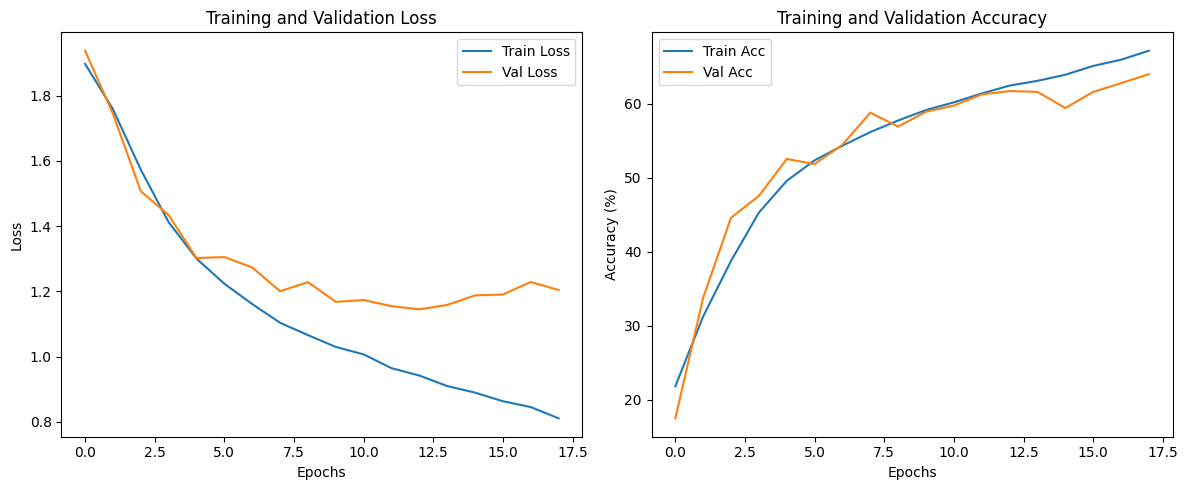

Testing:   0%|          | 0/57 [00:00<?, ?it/s]

Original pixel range: min=0.007843137718737125, max=0.9647058844566345
Test Accuracy: 62.06%

Classification Report:
              precision    recall  f1-score   support

       Angry       0.51      0.56      0.53       455
     Disgust       0.42      0.75      0.54        60
        Fear       0.50      0.35      0.41       513
       Happy       0.87      0.82      0.84       907
         Sad       0.49      0.52      0.50       609
    Surprise       0.70      0.80      0.75       423
     Neutral       0.55      0.57      0.56       623

    accuracy                           0.62      3590
   macro avg       0.58      0.62      0.59      3590
weighted avg       0.62      0.62      0.62      3590



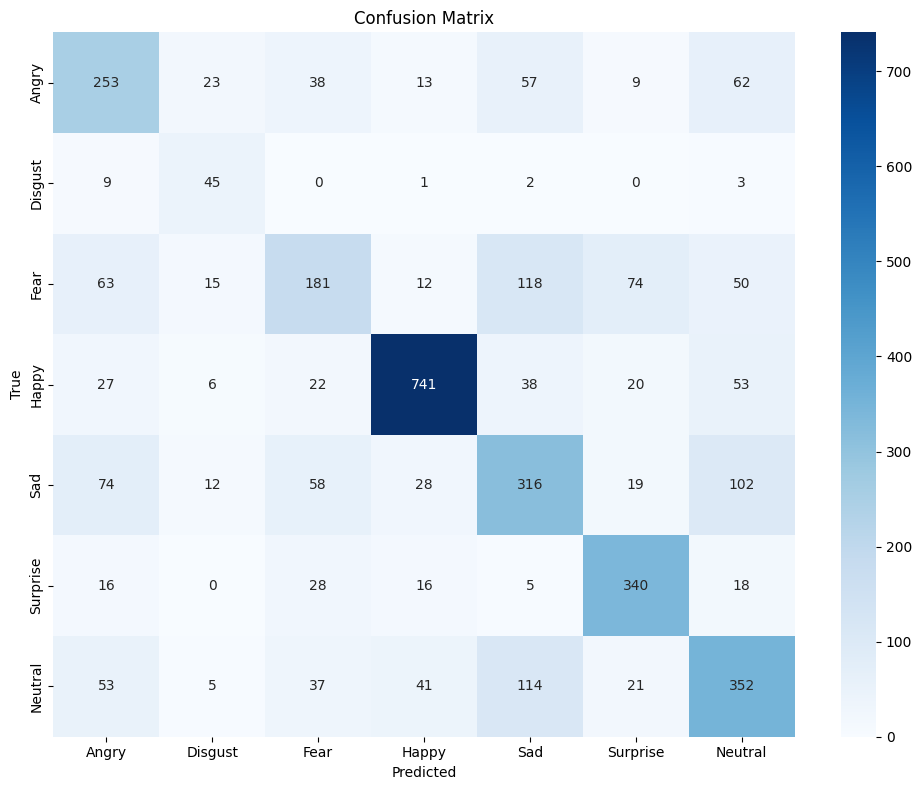


Per-class accuracy:
Angry: 0.5560
Disgust: 0.7500
Fear: 0.3528
Happy: 0.8170
Sad: 0.5189
Surprise: 0.8038
Neutral: 0.5650
Extracting features for potential multimodal integration...


Extracting Features:   0%|          | 0/57 [00:00<?, ?it/s]

Original pixel range: min=0.007843137718737125, max=0.9647058844566345


AttributeError: 'ResNetForImageClassification' object has no attribute 'backbone'

In [60]:
main()

In [65]:
# Advanced Model Inspection and Feature Extraction Script
# Run this in a single Google Colab cell

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
from transformers import AutoImageProcessor, AutoModelForImageClassification, ResNetForImageClassification

# ===== CONFIGURATION =====
SPECIFIC_CHECKPOINT_PATH = "/content/local_checkpoints/best_model.pt"
CSV_PATH = "/content/drive/MyDrive/icml_face_data/icml_face_data.csv"
OUTPUT_DIR = "/content/drive/MyDrive/icml_face_data/features"
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_WORKERS = 4

# Class mapping
CLASS_NAMES = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

# Set device for GPU acceleration
device = torch.device('cuda' if torch.cuda.is_available() else
                     'mps' if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() else
                     'cpu')
print(f"Using device: {device}")

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.dirname(SPECIFIC_CHECKPOINT_PATH), exist_ok=True)

# FER2013 Dataset class
class FER2013Dataset(Dataset):
    """Custom Dataset for loading FER2013 data"""
    def __init__(self, data, transform=None, train=False):
        self.data = data
        self.transform = transform
        self.train = train

        # Clean up column names by stripping whitespace
        self.data.columns = self.data.columns.str.strip()
        print(f"Dataset columns: {self.data.columns.tolist()}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            # Get the row
            row = self.data.iloc[idx]

            # Access pixels
            pixel_string = row['pixels']

            # Split pixel string into values
            if isinstance(pixel_string, str):
                pixels = [float(p) for p in pixel_string.split()]
            else:
                raise ValueError(f"Unexpected pixel type: {type(pixel_string)}")

            # Convert to array and reshape
            pixels = np.array(pixels, dtype=np.float32).reshape(48, 48)

            # Normalize to [0, 1]
            pixels = pixels / 255.0

            # Convert to RGB by repeating grayscale channel
            image = np.repeat(pixels[:, :, np.newaxis], 3, axis=2)

            if self.transform:
                # Use Albumentations for transformation
                augmented = self.transform(image=image)
                image = augmented['image']

            # Get label
            label = int(row['emotion'])

            return image, label

        except Exception as e:
            print(f"Error processing row {idx}: {str(e)}")
            # Return a placeholder
            placeholder_image = np.zeros((48, 48, 3), dtype=np.float32)
            if self.transform:
                augmented = self.transform(image=placeholder_image)
                placeholder_image = augmented['image']
            return placeholder_image, 0

# Load dataset function
def load_dataset(csv_path):
    """Load the FER2013 dataset from CSV"""
    print(f"Loading data from {csv_path}...")

    try:
        data = pd.read_csv(csv_path)
        print(f"Dataset loaded: {len(data)} samples")

        # Check if 'Usage' column exists for predefined train/test split
        if 'Usage' in data.columns:
            train_data = data[data['Usage'] == 'Training']
            val_data = data[data['Usage'] == 'PublicTest']
            test_data = data[data['Usage'] == 'PrivateTest']

            print(f"Train data: {len(train_data)}")
            print(f"Validation data: {len(val_data)}")
            print(f"Test data: {len(test_data)}")

            return train_data, val_data, test_data
        else:
            # If no predefined split, use the entire dataset as test
            print("No 'Usage' column found. Using entire dataset.")
            return data, data, data

    except Exception as e:
        print(f"Error loading dataset: {e}")
        raise

# Create data loader
def create_dataloader(data, batch_size=BATCH_SIZE):
    """Create data loader for feature extraction"""
    # Test/validation transform (no augmentation)
    transform = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
        ToTensorV2(),
    ])

    # Create dataset
    dataset = FER2013Dataset(data, transform=transform, train=False)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False,
    )

    return dataloader

# Load model
def load_model():
    """Load the ResNet model architecture"""
    try:
        # Try to load the model
        model_name = "microsoft/resnet-50"
        print(f"Loading model architecture: {model_name}")

        model = ResNetForImageClassification.from_pretrained(
            model_name,
            num_labels=len(CLASS_NAMES),
            ignore_mismatched_sizes=True
        )

        # Move model to device
        model = model.to(device)
        print(f"Model loaded with {sum(p.numel() for p in model.parameters())} parameters")

        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        raise

# Helper function to deeply inspect the model structure
def inspect_model(model):
    """Deeply inspect the model architecture to understand its structure"""
    print("\n===== MODEL INSPECTION =====")

    # Print top-level attributes
    print("Top-level attributes:")
    for attr_name in dir(model):
        if not attr_name.startswith('_') and not callable(getattr(model, attr_name)):
            try:
                attr = getattr(model, attr_name)
                if isinstance(attr, (nn.Module, torch.Tensor)):
                    print(f"- {attr_name}: {type(attr)}")

                    # If it's a module, examine its children too
                    if isinstance(attr, nn.Module):
                        print(f"  Children of {attr_name}:")
                        for child_name, child in attr.named_children():
                            print(f"  - {child_name}: {type(child)}")
            except Exception as e:
                print(f"- {attr_name}: Error accessing ({e})")

    # Examine model layers more deeply
    print("\nModel layers:")

    for name, module in model.named_modules():
        if "resnet" in name and isinstance(module, nn.Module) and not any(isinstance(child, nn.Module) for child in module.children()):
            # Leaf modules inside resnet
            print(f"- {name}: {type(module)}")

    # Find key layers for feature extraction
    print("\nPotential feature extraction points:")
    feature_layers = []
    for name, module in model.named_modules():
        if isinstance(module, (nn.AdaptiveAvgPool2d, nn.AvgPool2d, nn.Linear)):
            print(f"- {name}: {type(module)}")
            feature_layers.append(name)
        elif 'layer4' in name and not '.' in name.split('layer4')[1]:
            print(f"- {name}: {type(module)}")
            feature_layers.append(name)

    # Get the full structure for debugging
    print("\nFull module structure:")
    all_modules = list(model.named_modules())
    for i, (name, module) in enumerate(all_modules):
        if i < 20 or i > len(all_modules) - 20:  # Print first and last 20 modules
            print(f"- {name}: {type(module)}")
        elif i == 20:
            print("... (truncated for brevity) ...")

    return feature_layers

# Extract features using hooks - FIXED VERSION
def extract_features_with_hooks(model, dataloader):
    """Extract features using forward hooks to capture intermediate activations"""
    model.eval()
    all_features = []
    all_labels = []

    # First, deeply inspect the model structure
    feature_layers = inspect_model(model)

    # Try a simple forward pass to understand what outputs we get
    print("\nTest forward pass:")
    try:
        sample_input = next(iter(dataloader))[0][:1].to(device)
        outputs = model(sample_input)
        print(f"Outputs type: {type(outputs)}")

        # Check output attributes
        if hasattr(outputs, '__dict__'):
            for attr_name in dir(outputs):
                if not attr_name.startswith('_') and not callable(getattr(outputs, attr_name)):
                    try:
                        attr = getattr(outputs, attr_name)
                        print(f"- {attr_name}: {type(attr)}")
                        if isinstance(attr, torch.Tensor):
                            print(f"  Shape: {attr.shape}")
                    except:
                        pass

        # If it's just a tensor
        elif isinstance(outputs, torch.Tensor):
            print(f"Output tensor shape: {outputs.shape}")

    except Exception as e:
        print(f"Error in test forward pass: {e}")

    # Set up hooks to capture features from multiple layers
    activation = {}

    # FIX: Modified hook function to handle complex outputs
    def get_activation(name):
        def hook(model, input, output):
            # Handle different types of outputs
            if hasattr(output, 'last_hidden_state'):
                activation[name] = output.last_hidden_state
            elif hasattr(output, 'hidden_states') and output.hidden_states is not None:
                activation[name] = output.hidden_states[-1]  # Get the last hidden state
            elif hasattr(output, 'pooler_output'):
                activation[name] = output.pooler_output
            elif isinstance(output, torch.Tensor):
                activation[name] = output
            else:
                # Try to extract something useful from the output
                print(f"Complex output type for {name}: {type(output)}")
                for attr_name in dir(output):
                    if not attr_name.startswith('_') and not callable(getattr(output, attr_name)):
                        attr = getattr(output, attr_name)
                        if isinstance(attr, torch.Tensor):
                            print(f"Using {attr_name} from output for {name}, shape: {attr.shape}")
                            activation[name] = attr
                            break
        return hook

    # Register hooks for various potential feature layers
    hooks = []
    potential_feature_points = []

    # Option 1: Look for layers with specific names
    for name, module in model.named_modules():
        # Try to identify likely feature extraction points
        if any(point in name for point in ['layer4', 'pooler', 'avgpool', 'embeddings', 'encoder.layer.11']):
            potential_feature_points.append(name)
            hooks.append(module.register_forward_hook(get_activation(name)))
            print(f"Registered hook for: {name}")

    # Option 2: Use model-specific knowledge (add for specific models)
    if hasattr(model, 'resnet'):
        # For ResNetForImageClassification
        potential_feature_points.append('resnet_output')
        hooks.append(model.resnet.register_forward_hook(get_activation('resnet_output')))
        print("Registered hook for: resnet_output")

    # Process the data
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Extracting Features"):
            # Move inputs to device
            inputs = inputs.to(device)

            # Forward pass - this will trigger all hooks
            outputs = model(inputs)

            # FIX: Directly use outputs if hooks don't capture anything useful
            if hasattr(outputs, 'logits'):
                # Store the logits tensor
                extracted_features = outputs.logits
            elif hasattr(outputs, 'last_hidden_state'):
                extracted_features = outputs.last_hidden_state[:, 0]  # CLS token
            elif isinstance(outputs, torch.Tensor):
                extracted_features = outputs
            else:
                extracted_features = None

            # Choose the best feature representation from hooks or outputs
            feature_tensor = None

            # 1. First try pre-classification features from hooks if available
            for name in potential_feature_points:
                if name in activation and activation[name] is not None:
                    feat = activation[name]

                    # Process the feature based on its dimensionality
                    if feat.dim() > 2:
                        # If it's a feature map (from convolution), apply global avg pooling
                        feat = torch.nn.functional.adaptive_avg_pool2d(feat, (1, 1))
                        feat = torch.flatten(feat, 1)

                    # Prioritize later layers which have more semantic features
                    if feature_tensor is None or 'layer4' in name or 'output' in name:
                        feature_tensor = feat
                        if 'layer4' in name or 'output' in name:
                            print(f"Using features from: {name}, shape: {feat.shape}")
                            break

            # 2. If no good features found from hooks, use extracted_features
            if feature_tensor is None and extracted_features is not None:
                feature_tensor = extracted_features
                print(f"Using direct model outputs, shape: {extracted_features.shape}")

            # 3. If still no features, try to get something from model outputs
            if feature_tensor is None:
                print("No features captured, attempting alternative extraction")

                # Try to get something useful from the model outputs
                if hasattr(outputs, 'pooler_output'):
                    feature_tensor = outputs.pooler_output
                    print(f"Using pooler_output, shape: {feature_tensor.shape}")
                elif hasattr(outputs, 'hidden_states') and outputs.hidden_states is not None:
                    feature_tensor = outputs.hidden_states[-1][:, 0]  # Last layer, CLS token
                    print(f"Using last hidden state, shape: {feature_tensor.shape}")

            # If we still don't have features, skip this batch
            if feature_tensor is None:
                print(f"Warning: Could not extract features for this batch")
                continue

            # Store features and labels
            all_features.append(feature_tensor.cpu().numpy())
            all_labels.append(targets.numpy())

    # Remove all hooks
    for hook in hooks:
        hook.remove()

    # Concatenate all features and labels
    if all_features and all_labels:
        all_features = np.concatenate(all_features, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)
        print(f"Extracted features shape: {all_features.shape}")
        return all_features, all_labels
    else:
        print("Warning: No features were extracted!")
        return np.array([]), np.array([])

# Main execution function with improved checkpoint loading
def extract_features_from_checkpoint():
    """Main function to extract features from a checkpoint"""
    # 1. Load the dataset
    _, _, test_data = load_dataset(CSV_PATH)

    # 2. Create dataloader
    test_loader = create_dataloader(test_data)

    # 3. Load model architecture
    model = load_model()

    # 4. Check if checkpoint exists
    if os.path.exists(SPECIFIC_CHECKPOINT_PATH):
        # 5. Load checkpoint
        try:
            print(f"Loading checkpoint from {SPECIFIC_CHECKPOINT_PATH}")
            # Load with map_location to handle GPU/CPU differences
            checkpoint = torch.load(SPECIFIC_CHECKPOINT_PATH, map_location=device)

            # Handle different checkpoint formats
            if isinstance(checkpoint, dict):
                if 'model_state_dict' in checkpoint:
                    # Checkpoint contains state_dict as a key
                    state_dict = checkpoint['model_state_dict']
                    print(f"Loaded checkpoint dictionary (epoch {checkpoint.get('epoch', 'unknown')})")
                    if 'val_acc' in checkpoint:
                        print(f"Validation accuracy: {checkpoint['val_acc']:.2f}%")
                else:
                    # Assume it's already a state dict
                    state_dict = checkpoint
                    print("Loaded checkpoint as state dict")
            else:
                # Checkpoint is not a dictionary (unusual)
                print(f"Warning: Checkpoint is not a dictionary: {type(checkpoint)}")
                state_dict = checkpoint

            # Print some information about the state dict
            print(f"State dict contains {len(state_dict)} parameters")

            # Try loading the state dict
            try:
                missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
                if missing_keys:
                    print(f"Warning: {len(missing_keys)} missing keys when loading checkpoint")
                    print(f"First few missing keys: {missing_keys[:5]}")
                if unexpected_keys:
                    print(f"Warning: {len(unexpected_keys)} unexpected keys in checkpoint")
                    print(f"First few unexpected keys: {unexpected_keys[:5]}")

                print("Checkpoint loaded successfully (with some warnings)")
            except Exception as e:
                print(f"Error during load_state_dict: {e}")

                # Try to find matching parameters and load them manually
                print("Attempting to load compatible parameters only...")
                model_dict = model.state_dict()

                # Filter out incompatible keys
                compatible_state_dict = {k: v for k, v in state_dict.items()
                                         if k in model_dict and v.shape == model_dict[k].shape}

                print(f"Found {len(compatible_state_dict)}/{len(model_dict)} compatible parameters")

                # Load compatible parameters
                model_dict.update(compatible_state_dict)
                model.load_state_dict(model_dict)
                print("Loaded compatible parameters")

        except Exception as e:
            print(f"Error loading checkpoint: {e}")
            print("Will proceed with initial model weights!")
    else:
        print(f"Warning: Checkpoint not found at {SPECIFIC_CHECKPOINT_PATH}")
        print("Will proceed with initial model weights!")

    # 6. Extract features using hooks (more robust method)
    features, labels = extract_features_with_hooks(model, test_loader)

    # 7. Save features to disk
    if len(features) > 0:
        print(f"Saving {len(features)} extracted features to disk...")
        output_path = os.path.join(OUTPUT_DIR, 'extracted_features.npz')
        np.savez(output_path, features=features, labels=labels)
        print(f"Features saved to {output_path}")

        # Also save a sample in CSV format for easier inspection
        sample_size = min(100, len(features))
        sample_features = features[:sample_size]
        sample_labels = labels[:sample_size]

        # Create a DataFrame with label and first 10 feature dimensions
        sample_df = pd.DataFrame({
            'label': sample_labels,
            'emotion': [CLASS_NAMES[int(label)] for label in sample_labels]
        })

        # Add first 10 feature dimensions (or fewer if features has fewer dimensions)
        for i in range(min(10, sample_features.shape[1])):
            sample_df[f'feature_{i}'] = sample_features[:, i]

        sample_path = os.path.join(OUTPUT_DIR, 'feature_sample.csv')
        sample_df.to_csv(sample_path, index=False)
        print(f"Feature sample saved to {sample_path}")
    else:
        print("No features were extracted. Nothing to save.")

# Run the feature extraction
if __name__ == "__main__":
    print("=== Starting Feature Extraction ===")
    extract_features_from_checkpoint()
    print("=== Feature Extraction Complete ===")

Using device: cuda
=== Starting Feature Extraction ===
Loading data from /content/drive/MyDrive/icml_face_data/icml_face_data.csv...
Dataset loaded: 35887 samples
No 'Usage' column found. Using entire dataset.
Dataset columns: ['emotion', 'Usage', 'pixels']
Loading model architecture: microsoft/resnet-50


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([7, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded with 23522375 parameters
Loading checkpoint from /content/local_checkpoints/best_model.pt
Loaded checkpoint as state dict
State dict contains 320 parameters
Checkpoint loaded successfully (with some warnings)

===== MODEL INSPECTION =====
Top-level attributes:

Model layers:
- resnet.embedder.embedder.convolution: <class 'torch.nn.modules.conv.Conv2d'>
- resnet.embedder.embedder.normalization: <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
- resnet.embedder.embedder.activation: <class 'torch.nn.modules.activation.ReLU'>
- resnet.embedder.pooler: <class 'torch.nn.modules.pooling.MaxPool2d'>
- resnet.encoder.stages.0.layers.0.shortcut.convolution: <class 'torch.nn.modules.conv.Conv2d'>
- resnet.encoder.stages.0.layers.0.shortcut.normalization: <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
- resnet.encoder.stages.0.layers.0.layer.0.convolution: <class 'torch.nn.modules.conv.Conv2d'>
- resnet.encoder.stages.0.layers.0.layer.0.normalization: <class 'torch.nn.modules.batchn

Extracting Features:   0%|          | 0/561 [00:00<?, ?it/s]

Using features from: resnet_output, shape: torch.Size([64, 2048])
Using features from: resnet_output, shape: torch.Size([64, 2048])
Using features from: resnet_output, shape: torch.Size([64, 2048])
Using features from: resnet_output, shape: torch.Size([64, 2048])
Using features from: resnet_output, shape: torch.Size([64, 2048])
Using features from: resnet_output, shape: torch.Size([64, 2048])
Using features from: resnet_output, shape: torch.Size([64, 2048])
Using features from: resnet_output, shape: torch.Size([64, 2048])
Using features from: resnet_output, shape: torch.Size([64, 2048])
Using features from: resnet_output, shape: torch.Size([64, 2048])
Using features from: resnet_output, shape: torch.Size([64, 2048])
Using features from: resnet_output, shape: torch.Size([64, 2048])
Using features from: resnet_output, shape: torch.Size([64, 2048])
Using features from: resnet_output, shape: torch.Size([64, 2048])
Using features from: resnet_output, shape: torch.Size([64, 2048])
Using feat